In [3]:
import torch
import numpy as np


# テストデータを生成する関数
def generate_test_data(batch_size=2, seq_len=5, embed_size=128):
    """テスト用のランダムデータを生成"""
    data = {
        "d": torch.randint(0, 30, (batch_size, seq_len)),
        "t": torch.randint(0, 24, (batch_size, seq_len)),
        "input_x": torch.randint(0, 200, (batch_size, seq_len)),
        "input_y": torch.randint(0, 200, (batch_size, seq_len)),
        "time_delta": torch.randint(0, 10, (batch_size, seq_len)),
        "label_x": torch.randint(0, 200, (batch_size, seq_len)),
        "label_y": torch.randint(0, 200, (batch_size, seq_len)),
        "len": torch.randint(1, seq_len + 1, (batch_size,)),
    }
    return data


# 95%信頼区間を計算する関数
def calculate_95_percentile(data, mask):
    """データの95%信頼区間を計算"""
    data_np = data[mask].cpu().numpy()
    lower_bound = np.percentile(data_np, 2.5)
    upper_bound = np.percentile(data_np, 97.5)
    return lower_bound, upper_bound

In [8]:
def test_prediction_on_test_data():
    # テストデータを生成
    data = generate_test_data()
    print("Input X:", data["input_x"])
    print("Input Y:", data["input_y"])

    # マスクを作成（簡単な例としてinput_xが100未満の場所をマスクとする）
    pred_mask = data["input_x"] < 100

    # input_xとinput_yの95%信頼区間を計算
    non_mask = ~pred_mask
    lower_x, upper_x = calculate_95_percentile(data["input_x"], non_mask)
    lower_y, upper_y = calculate_95_percentile(data["input_y"], non_mask)

    print(f"95% Confidence Interval for X: [{lower_x}, {upper_x}]")
    print(f"95% Confidence Interval for Y: [{lower_y}, {upper_y}]")

    # outputとしてランダムなテンソルを生成（実験のため）
    output = torch.rand(
        (data["input_x"].shape[0], data["input_x"].shape[1], 2, 200)
    )  # (Batch Size, Sequence Length, 2, 200)

    # 信頼区間に基づく予測値の修正処理
    for step in range(data["input_x"].shape[1]):

        # x座標が95%信頼区間外ならその要素を0にする
        output[step][0] = torch.where(
            (output[step][0] < lower_x) | (output[step][0] > upper_x),
            torch.zeros_like(output[step][0]),
            output[step][0],
        )

        # y座標が95%信頼区間外ならその要素を0にする
        output[step][1] = torch.where(
            (output[step][1] < lower_y) | (output[step][1] > upper_y),
            torch.zeros_like(output[step][1]),
            output[step][1],
        )

    print("Modified Output X (Step 0):", output[:, 0, 0])
    print("Modified Output Y (Step 0):", output[:, 0, 1])

    # 最大値のインデックスを確認
    pred_x = torch.argmax(output[:, 0, 0], dim=-1)
    pred_y = torch.argmax(output[:, 0, 1], dim=-1)

    print("Predicted X:", pred_x)
    print("Predicted Y:", pred_y)

In [17]:
output = torch.rand((30, 15, 2, 200))

In [18]:
output.shape

torch.Size([30, 15, 2, 200])

In [22]:
output[0][0][0].shape

torch.Size([200])

In [30]:
lower_x = 50
upper_x = 150

output[0][0][0][:lower_x] = 0
output[0][0][0][upper_x:] = 0

In [31]:
output[0][0][0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7006, 0.4941, 0.0978, 0.9069,
        0.1692, 0.7643, 0.9438, 0.0473, 0.8720, 0.9358, 0.7005, 0.1497, 0.2745,
        0.6766, 0.2225, 0.9912, 0.5649, 0.4029, 0.3275, 0.9184, 0.8596, 0.7537,
        0.8281, 0.1770, 0.0449, 0.0277, 0.8523, 0.2867, 0.8168, 0.1911, 0.2679,
        0.7751, 0.6985, 0.5829, 0.2618, 0.2281, 0.3669, 0.2978, 0.2145, 0.0736,
        0.5518, 0.6523, 0.0566, 0.4767, 0.4921, 0.3649, 0.4238, 0.6380, 0.7666,
        0.7555, 0.2252, 0.2933, 0.6332, 0.2961, 0.5434, 0.5188, 0.5876, 0.2590,
        0.8074, 0.8607, 0.4031, 0.8344, 

In [ ]:
torch.where(
    (output[0][0][0] < lower_x) | (output[0][0][0] > upper_x),
    torch.zeros_like(output[step][0]),  # 条件に一致する要素はゼロ
    output[step][0],  # 条件に一致しない要素はそのまま残す
)

In [1]:
import torch
import torch.nn as nn


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec

In [1]:
import polars as pl
import numpy as np

# CSV.GZファイルを読み込む
df_b_poi = pl.read_csv("/kaggle/s3storage/01_public/humob-challenge-2024/input/POIdata_cityB.csv")

# データフレームの内容を表示
display(df_b_poi.head(1))
print(len(df_b_poi))

x,y,category,POI_count
i64,i64,i64,i64
1,1,79,2


56181


In [8]:
def create_poi_tensor(poi_path, grid_size=200):

    # CSV.GZファイルを読み込む
    poi_data = pl.read_csv(poi_path)

    # 200 x 200 のグリッドを初期化 (初期値はすべて0)
    poi_grid = np.zeros((grid_size, grid_size), dtype=np.float32)

    # POIデータを座標ごとにグリッドに加算
    for row in poi_data.iter_rows():
        x, y, poi_count = row[0] - 1, row[1] - 1, row[3]  # x, y, POI_count に対応
        poi_grid[x, y] += poi_count  # 座標に基づいてPOIの数を加算

    poi_tensor = torch.tensor(poi_grid).unsqueeze(0)  # (1, 200, 200)
    poi_tensor = torch.log1p(poi_tensor)
    poi_tensor = (poi_tensor - poi_tensor.min()) / (poi_tensor.max() - poi_tensor.min())

    return poi_tensor


poi_path = "/kaggle/s3storage/01_public/humob-challenge-2024/input/POIdata_cityB.csv"
poi_tensor = create_poi_tensor(poi_path, grid_size=200)

In [11]:
poi_tensor.unique()

tensor([0.0000, 0.0869, 0.1378, 0.1739, 0.2019, 0.2247, 0.2441, 0.2608, 0.2756,
        0.2888, 0.3007, 0.3117, 0.3217, 0.3310, 0.3396, 0.3477, 0.3553, 0.3625,
        0.3693, 0.3757, 0.3818, 0.3877, 0.3933, 0.3986, 0.4037, 0.4086, 0.4134,
        0.4179, 0.4223, 0.4266, 0.4307, 0.4347, 0.4385, 0.4423, 0.4459, 0.4494,
        0.4529, 0.4562, 0.4595, 0.4627, 0.4658, 0.4688, 0.4717, 0.4746, 0.4774,
        0.4802, 0.4829, 0.4855, 0.4881, 0.4906, 0.4931, 0.4956, 0.4980, 0.5003,
        0.5026, 0.5049, 0.5071, 0.5093, 0.5114, 0.5135, 0.5156, 0.5176, 0.5196,
        0.5216, 0.5236, 0.5255, 0.5274, 0.5292, 0.5310, 0.5328, 0.5346, 0.5364,
        0.5381, 0.5398, 0.5415, 0.5432, 0.5448, 0.5464, 0.5480, 0.5496, 0.5512,
        0.5527, 0.5542, 0.5557, 0.5572, 0.5587, 0.5601, 0.5616, 0.5630, 0.5658,
        0.5671, 0.5685, 0.5698, 0.5712, 0.5725, 0.5738, 0.5751, 0.5763, 0.5788,
        0.5801, 0.5813, 0.5825, 0.5837, 0.5861, 0.5872, 0.5884, 0.5895, 0.5918,
        0.5929, 0.5940, 0.5951, 0.5962, 

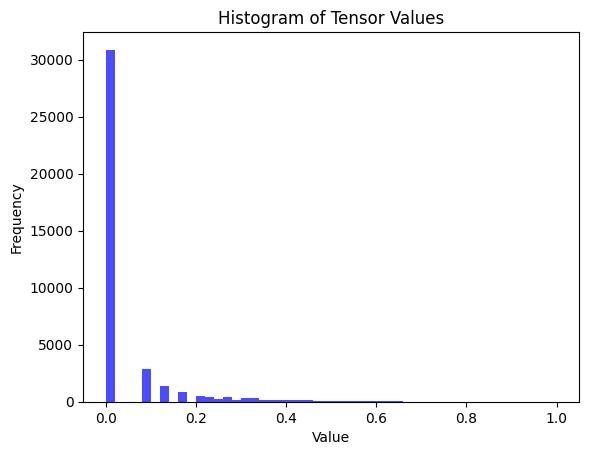

In [9]:
import matplotlib.pyplot as plt

# テンソルを1次元に変換
tensor_data_flat = poi_tensor.flatten().numpy()

# ヒストグラムを描画
plt.hist(tensor_data_flat, bins=50, color="blue", alpha=0.7)
plt.title("Histogram of Tensor Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class POIConvNet(nn.Module):
    def __init__(self):
        super(POIConvNet, self).__init__()

        # POIデータの畳み込み層を定義 (2D Convolution)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Global Poolingで(200, 200)を(16,)のベクトルに
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, poi_tensor):
        # 畳み込み処理を行う
        x = F.relu(self.conv1(poi_tensor))  # (Batch Size, 32, 200, 200)
        x = F.relu(self.conv2(x))  # (Batch Size, 64, 200, 200)
        x = F.relu(self.conv3(x))  # (Batch Size, 128, 200, 200)

        # Global Poolingで(128, 1, 1)に縮約し、(128,)のベクトルに
        x = self.global_pool(x).squeeze(-1).squeeze(-1)  # (Batch Size, 16)

        return x

In [37]:
# モデルのインスタンス化
model = POIConvNet()

# モデルにデータを渡して出力
output = model(poi_tensor)

In [38]:
output

tensor([9.2348e-03, 1.0738e-02, 4.1894e-02, 1.5464e-02, 5.9217e-02, 2.1519e-07,
        6.6741e-05, 5.2256e-05, 0.0000e+00, 4.5652e-07, 5.6105e-02, 1.9597e-02,
        2.3942e-02, 3.8399e-06, 6.9029e-06, 1.1223e-02, 3.6792e-03, 1.6327e-07,
        7.6504e-06, 6.2128e-08, 0.0000e+00, 1.8511e-04, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.5006e-07, 7.3431e-02, 6.0761e-02, 4.1900e-04, 5.3478e-05,
        4.7623e-05, 3.7756e-02, 0.0000e+00, 2.9795e-05, 0.0000e+00, 9.9337e-03,
        7.1974e-08, 0.0000e+00, 2.1124e-04, 5.9523e-02, 0.0000e+00, 4.5571e-02,
        1.3935e-07, 2.5389e-02, 0.0000e+00, 5.0845e-07, 4.0139e-05, 2.0917e-07,
        1.1574e-08, 1.9523e-04, 1.9417e-05, 4.4086e-03, 0.0000e+00, 2.7920e-02,
        1.9920e-02, 6.6468e-05, 0.0000e+00, 0.0000e+00, 2.3737e-04, 1.8968e-03,
        2.8165e-02, 0.0000e+00, 4.4270e-04, 1.8336e-02, 3.7096e-02, 0.0000e+00,
        3.6968e-02, 3.0274e-02, 1.2455e-02, 3.1101e-02, 7.0160e-02, 3.4761e-02,
        2.8095e-04, 1.3615e-04, 3.7793e-

In [25]:
output.shape

torch.Size([128])